In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.ensemble import ExtraTreesRegressor

import joblib
import gc
pd.set_option('display.max_columns', None)

## Loading Data

On garde l'ensemble des données et on concat

In [2]:
def load_df():
  #df_2016 = pd.read_csv("full_2016.csv")
  #df_2017 = pd.read_csv("full_2017.csv")
  #df_2018 = pd.read_csv("full_2018.csv")
  #df_2019 = pd.read_csv("full_2019.csv")
  df_2020 = pd.read_csv('full_2020.csv')
  #print(df_2019.columns, df_2020.columns)

  #df = pd.concat([df_2019, df_2020], ignore_index=True)

  #del df_2019
  #del df_2020
  #gc.collect()

  return df_2020

In [3]:
df = load_df()

C:\Users\mathy\Anaconda3\envs\NLP\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (8,10,12,14,16,17,18,20,22,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Data Preparation

Filtre uniquement sur les vente.

Garder mois et année en input ?

In [4]:
def modif(df):
  #df['date_mutation'] = pd.to_datetime(df['date_mutation'])
  #df['Month'] = df['date_mutation'].dt.month
  #df['Year'] = df['date_mutation'].dt.year

  mask_nature = df['nature_mutation'] == 'Vente'
  mask_type = df['type_local'] == 'Maison'
  df = df[mask_nature]
  df = df[mask_type]

  analysis_df = df[['valeur_fonciere', 'code_postal', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain']]
  analysis_df = analysis_df.drop_duplicates()
  return analysis_df

In [5]:
df_prep = modif(df)

C:\Users\mathy\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [6]:
def remove_NaN(df):
    return df.dropna()

In [7]:
print(df_prep.isnull().sum())
df_prep = remove_NaN(df_prep)
print(df_prep.isnull().sum())

valeur_fonciere               1089
code_postal                     19
surface_reelle_bati              4
nombre_pieces_principales        4
surface_terrain              20594
dtype: int64
valeur_fonciere              0
code_postal                  0
surface_reelle_bati          0
nombre_pieces_principales    0
surface_terrain              0
dtype: int64


## Features engineering

Stratify split sur le type de local pour preserver la proportion.

Dummification sur le type de local 

In [8]:
def define_data(data, column_predict):
    X = data.drop(columns=[column_predict]).values
    y = data[column_predict]
    return X, y

def dummification(data):
  dumm = pd.get_dummies(data, columns=['type_local'])
  dumm.head(5)
  return dumm

def Norm_Std_Scaler(data, columns):
    standard_scaler = StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = columns)
    return data_scaled

def train_test(input_, output):
    X_train, X_test, Y_train, Y_test = train_test_split(input_, output, train_size=0.8)
    return X_train, Y_train, X_test, Y_test

In [9]:
X, y = define_data(df_prep, 'valeur_fonciere')

#X = dummification(X)
X = Norm_Std_Scaler(X, ['code_postal', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain'])
X_train, Y_train, X_test, Y_test = train_test(X, y)


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(399155, 4) (399155,)
(99789, 4) (99789,)


In [10]:
def score(model):
    y_pred_test = model.predict(X_test)
    predictions_test = [round(value, 4) for value in y_pred_test]

    print('MAE of predictions on testing : %s' % MAE(Y_test, predictions_test))
    print('R² on Testing set : ', model.score(X_test, Y_test))

def score_cv(model): 

    y_pred_test = model.predict(X_test)
    predictions_test = [round(value, 4) for value in y_pred_test]

    # evaluate predictions
    print('MAE of predictions on testing : %s' % MAE(Y_test, predictions_test))

    print('Best Score: %s' % model.best_score_)
    print('Best Hyperparameters: %s' % model.best_params_)

## Model Building

On veut un model un modele rapide d'execution avec ces données on peut esperer un bonne performance d'un model de boosting ou ensembliste. On choisit donc :
- Un ligtGBM
- Un extraTrees 

On utilisera un RandomizedSearch pour la recherche de parametres avec un repeatedKfold pour la cross validation

In [11]:
xtrees = ExtraTreesRegressor()

rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)

parameters = { 
    'n_estimators': [200, 500],
    'max_depth' : [10,20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'criterion' :['mse']
}

In [12]:
xtrees.fit(X_train, Y_train)

ExtraTreesRegressor()

In [13]:
score(xtrees)

MAE of predictions on testing : 113982.48356990647
R² on Testing set :  0.8052274555209042


In [14]:
def var_importance(model):
	importance = model.feature_importances_# get importance

	for i,v in enumerate(importance): # summarize feature importance
		print('Feature: %0d, Score: %.5f' % (i,v))

	plt.bar([x for x in range(len(importance))], importance) # plot feature importance
	plt.show()

Feature: 0, Score: 0.29252
Feature: 1, Score: 0.17825
Feature: 2, Score: 0.06102
Feature: 3, Score: 0.46821


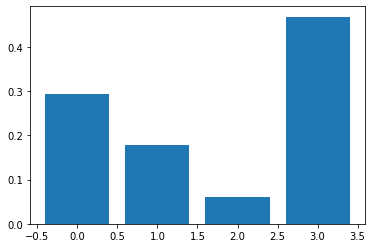

In [15]:
var_importance(xtrees)

In [16]:
def Graph_prediction(data, y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    TP = data['valeur_fonciere']
    number = len(data['surface_reelle_bati'])
    aa=[x for x in data['surface_reelle_bati']]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, y[:number], 'o', label='Real value')
    plt.plot(aa, y_total[:number], 'x', label='Predicted value')
    
    plt.xlabel('Surface', size=15)
    plt.ylabel('Valeur Fonciere', size=15)
    plt.title('Valeur Fonciere Prediction')
    plt.legend(fontsize=15)
    plt.show()

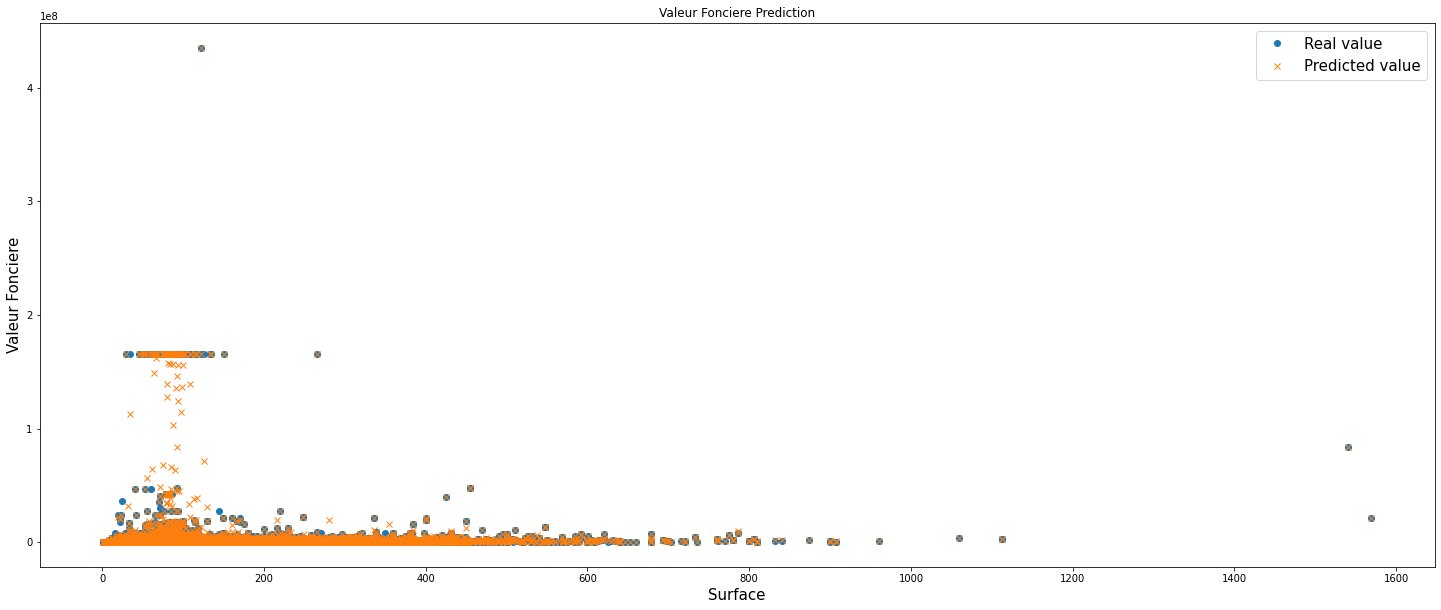

In [17]:
Graph_prediction(df_prep, y, xtrees.predict(X))

In [18]:
filename = 'ExtraTrees.sav'
joblib.dump(xtrees, filename)

['ExtraTrees.sav']

In [19]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

KeyboardInterrupt: 

In [ ]:
Graph_prediction(df_prep, y, xtrees_random.predict(X))

In [ ]:
var_importance(xtrees_random)